# Project 01 Benson

Phil Beltre, Christian Branton, James Mitchell, Lukas Wadya

### Read Data to Dataframe

In [1]:
import pandas as pd
import numpy as np

# Import data
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [181201, 181208, 181215, 181222, 181229,
             190105, 190112, 190119, 190126, 
             190202, 190209, 190216, 190223,
             190302, 190309, 190316, 190323, 190330]
turnstiles_df = get_data(week_nums)
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/24/2018,03:00:00,REGULAR,6845468,2321627
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/24/2018,07:00:00,RECOVR AUD,6845479,2321635
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/24/2018,11:00:00,RECOVR AUD,6845578,2321702
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/24/2018,15:00:00,RECOVR AUD,6845780,2321753
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/24/2018,19:00:00,REGULAR,6846083,2321818


### Clean Data (Part 1)

In [2]:
# Remove duplicate entries
turnstiles_df.sort_values(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME'], inplace=True, ascending=False)
turnstiles_df.drop_duplicates(subset=['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME'], inplace=True)

# Convert date to datetime
turnstiles_df['DATE'] = pd.to_datetime(turnstiles_df['DATE'], format='%m/%d/%Y')
#turnstiles_df.dtypes

### Calculate Entries per Day

In [3]:
entries_df = \
    (turnstiles_df.sort_values(by=['TIME'], ascending=False)
                  .groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DATE'], as_index=False)
                  ['ENTRIES']
                  .first())
entries_df['DAILY_ENTRIES'] = (entries_df.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME'])
                                         ['ENTRIES']
                                         .diff()
                                         .shift(-1))
#entries_df.head(5)

### Clean Data (Part 2)

In [4]:
# Invert neagative numbers and outliers
entries_df['DAILY_ENTRIES'] = entries_df['DAILY_ENTRIES'].abs()
entries_df[entries_df['DAILY_ENTRIES'] > 8000] = np.nan

### Combine Station and Linename into a Single Variable (where necessary)

In [5]:
separate_stations = ['23 ST', '86 ST']
df1 = entries_df[entries_df['STATION'].isin(separate_stations)]
df1['STATION_LINE'] = df1['STATION'] + ' ' + df1['LINENAME']
df2 = entries_df[~entries_df.STATION.isin(separate_stations)]
df2['STATION_LINE'] = df2['STATION']
entries_df = pd.concat([df1, df2], axis=0)
#entries_df.sample(10)

/Users/christianbranton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/christianbranton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### List *N* Busiest Stations

In [6]:
top_count = 50
per_station = (entries_df.groupby(['STATION_LINE'], as_index=False)
                         ['DAILY_ENTRIES']
                         .sum()
                         .sort_values(by=['DAILY_ENTRIES'], ascending=False))
tops_df = per_station.head(top_count).reset_index().drop(['index'], axis=1)
tops_df['DAILY_ENTRIES'] = tops_df['DAILY_ENTRIES'] / len(entries_df['DATE'].dropna().unique())
tops_df.head(15)

,STATION_LINE,DAILY_ENTRIES
0,34 ST-PENN STA,140962.944444
1,GRD CNTRL-42 ST,123142.388889
2,34 ST-HERALD SQ,106517.166667
3,42 ST-PORT AUTH,88229.436508
4,14 ST-UNION SQ,87101.928571
5,TIMES SQ-42 ST,84867.158730
6,FULTON ST,76393.039683
7,125 ST,66145.000000
8,CANAL ST,62808.865079
9,59 ST COLUMBUS,61940.031746


### Plot *N* Busiest Stations

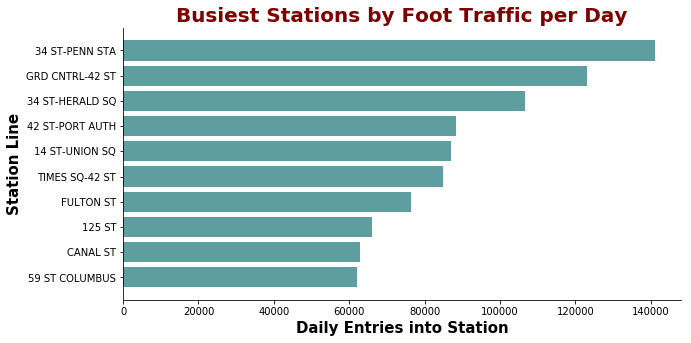

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
tops_df = tops_df.head(10)
plt.figure(figsize=(10, 5))
tops_display_df = tops_df.sort_values(by='DAILY_ENTRIES')
plt.barh(tops_display_df['STATION_LINE'], tops_display_df['DAILY_ENTRIES'], color = 'cadetblue');
plt.title('Busiest Stations by Foot Traffic per Day', fontweight = "bold", color ='maroon', fontsize=20)
plt.xlabel('Daily Entries into Station', fontsize=15, fontweight='bold')
plt.ylabel('Station Line', fontsize=15, fontweight='bold');
sns.despine()
plt.savefig('busstatfig.png', bbox_inches='tight')
#%config InlineBackend.figure_format = 'svg’, or
#fig.savefig(‘busieststationfig.svg’, format=’svg’)


### Merge Turnstile and Station Lat/Long Dataframes

In [8]:
# import latlong data
latlong_df = pd.read_csv('https://data.ny.gov/api/views/i9wp-a4ja/rows.csv?accessType=DOWNLOAD')

In [9]:
# import turnstile/latlong name conversion data
latlong_names_df = pd.read_csv('latlong_names.csv')

In [10]:
# merge turnstile and name conversion dataframes
all_mta_df = tops_df.merge(latlong_names_df, on='STATION_LINE', how='left')

# merge latlong dataframe
latlong_means_df = latlong_df.groupby(['Station Name'])['Station Latitude', 'Station Longitude'].mean()
all_mta_df = all_mta_df.merge(latlong_means_df, left_on='LL_NAME', right_on='Station Name', how='left')
#all_mta_df

### Create bar location list

In [11]:
import pandas as pd
df_liquor = pd.read_csv('https://data.ny.gov/api/views/hrvs-fxs2/rows.csv?accessType=DOWNLOAD')

#Applies filters
mask = ((df_liquor["Latitude"] != 0) & 
        (df_liquor["Longitude"] != 0) & 
        (df_liquor["Agency Zone Office Name"] == "New York City") &
        (df_liquor["License Class Code"] == 252))
df_liquor = df_liquor[mask]

#Drops missing lat/long entries
df_liquor = df_liquor.dropna(subset=['Latitude','Longitude'])

#Creates list-of-lists of bar locations to use later
lats = df_liquor['Latitude'].tolist()
lons = df_liquor['Longitude'].tolist()
names = df_liquor['Doing Business As (DBA)'].tolist()

bar_locs = [list(i) for i in zip(lats,lons,names)]

### Function for distance in km

In [12]:
#Arguments -> two lat/long coord pairs
from math import radians, sin, cos, acos

def distance(lat1,lon1,lat2,lon2):
  
    slat = radians(float(lat1))
    slon = radians(float(lon1))
    elat = radians(float(lat2))
    elon = radians(float(lon2))

    dist = 6371.01 * acos(sin(slat)*sin(elat) + cos(slat)*cos(elat)*cos(slon - elon))
    return(dist)

#Fn for finding number of bars within r km of a station
#Fn args -> 1) station's lat, 2) station's long, 3) a list of bar locations (2-element lists), 4) radius (in km)
def nearby_count(station_lat,station_lon,bar_loc_list,radius):
    nearby_bar_count = 0
    for bar in bar_locs:
        if distance(station_lat,station_lon,bar[0],bar[1]) < radius:
            nearby_bar_count += 1
    return(nearby_bar_count)


### Find number nearby bars and calculate ratio

In [13]:
# TEMP Converting name for combining notebooks 
df_mta = all_mta_df

#Count # bars within quarter and half km; then calc "entries/#proximate bars" cols
df_mta['Bars Within .25 km'] = df_mta.apply(lambda x: nearby_count(x['Station Latitude'], x['Station Longitude'],bar_locs,.25), axis=1)
df_mta['Bars Within .50 km'] = df_mta.apply(lambda x: nearby_count(x['Station Latitude'], x['Station Longitude'],bar_locs,.5), axis=1)
df_mta['EBRatio_.25km'] = round(df_mta['DAILY_ENTRIES']/df_mta['Bars Within .25 km'],2)
df_mta['EBRatio_.50km'] = round(df_mta['DAILY_ENTRIES']/df_mta['Bars Within .50 km'],2)

#Remove stations with no bars nearby
df_mta = df_mta[(df_mta["Bars Within .50 km"] != 0)]

#Add col for entries rank (ranking stat not used for any calcs)
df_mta['ENTRIES_RANK'] = df_mta['DAILY_ENTRIES'].rank(ascending=0) 

#Sort by EBRatio
df_mta = df_mta.sort_values(by='EBRatio_.50km',ascending = False)
df_mta

,STATION_LINE,DAILY_ENTRIES,LL_NAME,Station Latitude,Station Longitude,Bars Within .25 km,Bars Within .50 km,EBRatio_.25km,EBRatio_.50km,ENTRIES_RANK
7,125 ST,66145.000000,125th St,40.809510,-73.948289,2,23,33072.50,2875.87,8.0
6,FULTON ST,76393.039683,Fulton St,40.707411,-74.004122,21,48,3637.76,1591.52,7.0
1,GRD CNTRL-42 ST,123142.388889,Grand Central-42nd St,40.751738,-73.976758,21,102,5863.92,1207.28,2.0
0,34 ST-PENN STA,140962.944444,34th St,40.750882,-73.990876,20,118,7048.15,1194.60,1.0
2,34 ST-HERALD SQ,106517.166667,34th St,40.750882,-73.990876,20,118,5325.86,902.69,3.0
4,14 ST-UNION SQ,87101.928571,14th St-Union Square,40.734673,-73.989951,18,102,4839.00,853.94,5.0
8,CANAL ST,62808.865079,Canal St,40.720309,-74.003088,28,85,2243.17,738.93,9.0
9,59 ST COLUMBUS,61940.031746,59th St,40.736216,-73.986555,30,94,2064.67,658.94,10.0
3,42 ST-PORT AUTH,88229.436508,42nd St,40.755765,-73.987152,40,151,2205.74,584.30,4.0
5,TIMES SQ-42 ST,84867.158730,Times Square,40.755359,-73.987368,35,147,2424.78,577.33,6.0
